## 3. Getting Started with Neural Networks

### Classifying Movie Reviews: A Binary Classification Example
In the **reviews** problem, we intend to classify movie reviews as positive or negative based on the text content of the reviews.

In [1]:
from keras.datasets import imdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
##########
# Ingestion
##########
VOCABULARY_SIZE = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCABULARY_SIZE)

The dataset is the IMDB dataset, consisting of 50000 highly polarized reviews. Each review is represented as a vector, where each value representing a word in the vocabulary of the corpus. The labels are 0 indicating negative review and 1 indicating positive review.

In [3]:
# For testing
# print([td[:15] for td in train_data[0:3]])
# print(train_labels[0:3])

Preprocessing involves transforming the source data to data that can be consumed in the network. There are two candidate methods:
1. Pad the lists so all the lists have the same length, and then them into and integer tensor of shape (samples, word_indices) then use as the first layer in the network capable of handling such integer tensors
2. One-hot encode the list to turn the vectors into 0s and 1s. The vector size represents the vocabulary size of the corpus. 

We will use option 2.

In [4]:
##########
# Preprocessing
##########
def vectorize_sequences(sequences, dimension=VOCABULARY_SIZE):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
          results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Train-Validation Split
x_train__train, x_train__val, y_train__train, y_train__val = train_test_split(x_train, y_train, test_size=0.4,
                                                                             random_state=0)

A type of network that performs well for such problems is a simple stack of dense layers via <b>relu</b> activations. We will use 2 layers with 16 hidden units each and a third layer that outputs the scalar prediction regarding the sentiment of the review. The intermediate layers will use relu as the activation function and the final layers uses a sigmoid activation.

A `relu` (rectified linear unit) is a function meant to zero-out the negatives. That means that if the value is zero or positive, the output is the value. But if the value is negative, the output is just zero.

<img src="img2.png" width="450"/>

In [5]:
##########
# Instantiate Model
##########
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(VOCABULARY_SIZE,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Then we need to compile the model with the optimiser and loss function

In [6]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

We now train the model for 20 epochs in mini-batches of 512 samples. We also monitor the loss and accuracy of the validation set. This will be used to determine the optimum number of epochs the final model will have.

In [7]:
##########
# Train / Model Tuning
##########
history = model.fit(x_train__train, y_train__train, 
                    epochs=20, batch_size=512, 
                    validation_data=(x_train__val, y_train__val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 7s 442us/step - loss: 0.4997 - accuracy: 0.8050 - val_loss: 0.3796 - val_accuracy: 0.8697
Epoch 2/20
15000/15000 [==============================] - 3s 191us/step - loss: 0.2979 - accuracy: 0.9053 - val_loss: 0.3018 - val_accuracy: 0.8876
Epoch 3/20
15000/15000 [==============================] - 3s 203us/step - loss: 0.2178 - accuracy: 0.9313 - val_loss: 0.2813 - val_accuracy: 0.8907
Epoch 4/20
15000/15000 [==============================] - 3s 198us/step - loss: 0.1717 - accuracy: 0.9472 - val_loss: 0.3061 - val_accuracy: 0.8804
Epoch 5/20
15000/15000 [==============================] - 3s 198us/step - loss: 0.1423 - accuracy: 0.9568 - val_loss: 0.2820 - val_accuracy: 0.8920
Epoch 6/20
15000/15000 [==============================] - 3s 188us/step - loss: 0.1179 - accuracy: 0.9660 - val_loss: 0.3080 - val_accuracy: 0.8855
Epoch 7/20
15000/15000 [==============================] - 3s 1

We can use the `history` to plot training and validation loss over each epoch.

In [8]:
##########
# Model Evaluation
##########
history_dict = history.history
metrics_df = pd.DataFrame({'loss' : history_dict['loss'], 'val_loss' : history_dict['val_loss'],
                          'accuracy' : history_dict['accuracy'], 'val_accuracy' : history_dict['val_accuracy']})
metrics_df['epoch'] = metrics_df.index+1

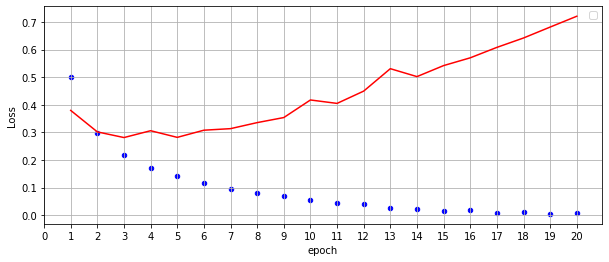

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax, label='validation', color='red')
ax.set_ylabel("Loss")
ax.grid('GAINSBORO')
ax.legend([])
ax.set_xticks(range(0,21))
plt.show()

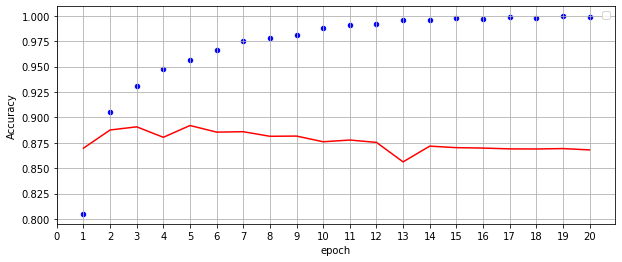

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax, label='validation', color='red')
ax.set_ylabel("Accuracy")
ax.grid('GAINSBORO')
ax.legend([])
ax.set_xticks(range(0,21))
plt.show()

As you can see, training loss decreases with every epoch and training accuracy increases with every epoch (blue . This is consistent because using the SGD algorithm, we get closer and closer to the minimum of the loss function for the training set. 

But this is not the case for valdation. Loss seems to pick up again starting from the 4th epoch. There is no notable improvement for accuracy beyond the 4th epoch.

Hence, we can see here that the model that is trained on the training data might not directly also perform well on the validation data. This is an example of <b>overfitting</b>. So let's stop after 5 epochs.

In [11]:
##########
# Train Tuned Model
##########
model2 = models.Sequential()
model2.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(x_train__train, y_train__train, 
           epochs=5, batch_size=512, 
           validation_data=(x_train__val, y_train__val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 2s 138us/step - loss: 0.4986 - accuracy: 0.7944 - val_loss: 0.4059 - val_accuracy: 0.8378
Epoch 2/5
15000/15000 [==============================] - 2s 126us/step - loss: 0.2938 - accuracy: 0.9038 - val_loss: 0.3271 - val_accuracy: 0.8710
Epoch 3/5
15000/15000 [==============================] - 2s 126us/step - loss: 0.2188 - accuracy: 0.9261 - val_loss: 0.2777 - val_accuracy: 0.8923
Epoch 4/5
15000/15000 [==============================] - 2s 128us/step - loss: 0.1690 - accuracy: 0.9444 - val_loss: 0.2790 - val_accuracy: 0.8922
Epoch 5/5
15000/15000 [==============================] - 2s 129us/step - loss: 0.1370 - accuracy: 0.9557 - val_loss: 0.2956 - val_accuracy: 0.8869


In [12]:
##########
# Evaluate on Test Set
##########
results = model2.evaluate(x_test, y_test)
print(results)

25000/25000 [==============================] - 4s 167us/step
[0.3233723027896881, 0.8716800212860107]


The final accuracy for the tuned model is 88%

In [13]:
##########
# Predict
##########
model2.predict(x_test[:3])

array([[0.14231093],
       [0.99975103],
       [0.74661314]], dtype=float32)